# Model-Based Decision Making

This notebook contains the final code of Group 30's assignment for the course EPA1361.

In this code, we explore scenarios for the studied policy problem (flood risk management for the IJssel river) using open exploration, and then apply directed search (MORDM) to find optimal results.

## Table of contents
1) [Set Up](#Set-up)
2) [Problem formulation 2](#Problem-formulation-2)
3) [Exploration](#Exploration)
4) [Optimization](#Optimization)
    - [Convergence](#Convergence)
    - [Constraints and solutions](#Constrain-solutions)
    - [Uncertainty](#Uncertainty)
    - [Scenario discovery using PRIM](#Scenario-Discovery)
5) [Robustness](#Robustness)
   - [Signal To Noise](#Robustness)
   - [Maximum Regret](#Maximum-regret) 

# Set up

In [61]:
# All needed imports
## Standard packages
!pip install ema_workbench
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from datetime import datetime
import json
import copy
from copy import deepcopy
from pathlib import Path
import collections

In [62]:
## initiating EMA workbench
from ema_workbench import (
    Policy,
    Scenario,
    HypervolumeMetric,
    ScalarOutcome,
    ema_logging,
    save_results,
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,)

#EMA workbench - optimization
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)

#EMA workbench - analysis
from ema_workbench.analysis import (
    parcoords,
    prim,
    dimensional_stacking,
    feature_scoring,
    scenario_discovery_util
)
## IJssel dike model
from dike_model_function import DikeNetwork  
from problem_formulation import get_model_for_problem_formulation, sum_over, sum_over_time

import math

In [63]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher

#!pip install xlrd>=2.0.1


import pandas as pd
import networkx as nx

print(pd.__version__)
print(nx.__version__)

2.2.2
3.2.1


In [64]:
# Set up logging
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [65]:
# Data and figure saving settings 
saving_plots = True
saving_exploration_data = False
saving_results_data = True

In [67]:
# Set up folders
base_path = Path.cwd()
if saving_plots:
    plots_path= base_path / "MBDM_Final_Assignments_Files" / "Plots"
    Path(plots_path).mkdir(parents=True, exist_ok=True)
if saving_exploration_data:
    exploration_data = base_path / "MBDM_Final_Assignments_Files" / "Optimization_Data"
    Path(exploration_data).mkdir(parents=True, exist_ok=True)
if saving_results_data:
    results_path = base_path / "MBDM_Final_Assignments_Files" / "Results"
    Path(results_path).mkdir(parents=True, exist_ok=True)

# Problem formulation 2

In [7]:
# Selecting problem formulation number 2
    # each problem formulation has its own list of outcomes and 2 suits Delta best 
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [8]:
#enlisting uncertainties, their types, lower boundary, and upper boundary
for unc in dike_model.uncertainties:
    print(repr(unc))

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False)
RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False)
RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False)
RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False)
RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfai

In [9]:
# enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))

levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('0_RfR 1', 0, 1, resolution=None, default=None, variable_name=['0_RfR 1'], pff=False)
IntegerParameter('0_RfR 2', 0, 1, resolution=None, default=None, variable_name=['0_RfR 2'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('1_RfR 1', 0, 1, resolution=None, default=None, variable_name=['1_RfR 1'], pff=False)
IntegerParameter('1_RfR 2', 0, 1, resolution=None, default=None, variable_name=['1_RfR 2'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('2_RfR 1', 0, 1, resolution=None, default=None, variable_name=['2_RfR 1'], pff=False)
IntegerParameter('2_RfR 2', 0, 1, resolution=None, default=None, variable_name=['2_RfR 2'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable

In [10]:
# enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('Expected Annual Damage', variable_name=('A.1_Expected Annual Damage', 'A.2_Expected Annual Damage', 'A.3_Expected Annual Damage', 'A.4_Expected Annual Damage', 'A.5_Expected Annual Damage'), function=<function sum_over at 0x0000021D70B48040>)
ScalarOutcome('Dike Investment Costs', variable_name=('A.1_Dike Investment Costs', 'A.2_Dike Investment Costs', 'A.3_Dike Investment Costs', 'A.4_Dike Investment Costs', 'A.5_Dike Investment Costs'), function=<function sum_over at 0x0000021D70B48040>)
ScalarOutcome('RfR Investment Costs', variable_name=('RfR Total Costs',), function=<function sum_over at 0x0000021D70B48040>)
ScalarOutcome('Evacuation Costs', variable_name=('Expected Evacuation Costs',), function=<function sum_over at 0x0000021D70B48040>)
ScalarOutcome('Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths', 'A.2_Expected Number of Deaths', 'A.3_Expected Number of Deaths', 'A.4_Expected Number of Deaths', 'A.5_Expected Number of Deaths'), function

In [11]:
# Function to get default values for all levers
def get_do_nothing_dict():
    return {l.name: 0 for l in dike_model.levers}

# Exploration

We will explore 3 policies:

1. A baseline (no actions taken)
2. Implementing room for the river (RfR) everywhere
3. The final policy of the MBDM debate, including RfR in dike rings 1 and 4, and moderate dike heightening in each dike ring

In [12]:
# defining specific policies
# policy 1 is about business as usual
# policy 2 is about impplementing room for river everywhere
# policy 3 is about the final debate outcome

# This function will return the policy list, based on the default values of problem formulation 2 .

def get_policies(do_nothing_dict):
    policies = []

    # Baseline policy: do nothing 
    policies.append(Policy("Baseline", **do_nothing_dict))

    # RfR everywhere policy
    rfr_everywhere = do_nothing_dict.copy()
    for dike_ring in range(5):  # 0 to 4
        for time_step in range(3):  # 0 to 2
            rfr_everywhere[f"{dike_ring}_RfR {time_step}"] = 1
    policies.append(Policy("RfR everywhere", **rfr_everywhere))

    # Policy preference from Delta (and Rijkswaterstaat) as a result of the debate
    final_policy = do_nothing_dict.copy()
    final_policy.update({
        '0_RfR 0': 1,  # Dike Ring A2 - Cortenoever (Room for the River)
        '2_RfR 0': 1,  # Dike Ring A3 - Zutphen (Room for the River)
        'DaysToThreat': 3,  # Days to Threat
        'A.1_DikeIncrease 0': 0.5,  # A1 - Doesburg: 50 cm
        'A.4_DikeIncrease 0': 0.7,  # A4 - Gorssel: 70 cm
        'A.5_DikeIncrease 0': 0.8   # A5 - Deventer: 80 cm
        })
    policies.append(Policy("Final approved policy", **final_policy))
  
    return policies

In [13]:
policies = get_policies(get_do_nothing_dict())

#Passes the policies list to EMA workbench experiment default Latin Hypercube Sampling
n_scenarios = 200
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios, policies)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 200 scenarios * 3 policies * 1 model(s) = 600 experiments
100%|████████████████████████████████████████| 600/600 [01:46<00:00,  5.62it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [14]:
#Saving the exploration results 
if saving_exploration_data:
    saving_results(results, f"{exploration_data}/PF2_exploration_results.tar.gz")

In [15]:
# observing the simulation runs
#separate results into experiments and outcomes, and select policies
experiments, outcomes = results
policies = experiments['policy']
print(outcomes.keys())

dict_keys(['Expected Annual Damage', 'Dike Investment Costs', 'RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths'])


In [16]:
# Convert outcomes to DataFrame and merge with policy labels
data = pd.DataFrame(outcomes)
data['policy'] = policies.reset_index(drop=True)

KeyError: 'policy'

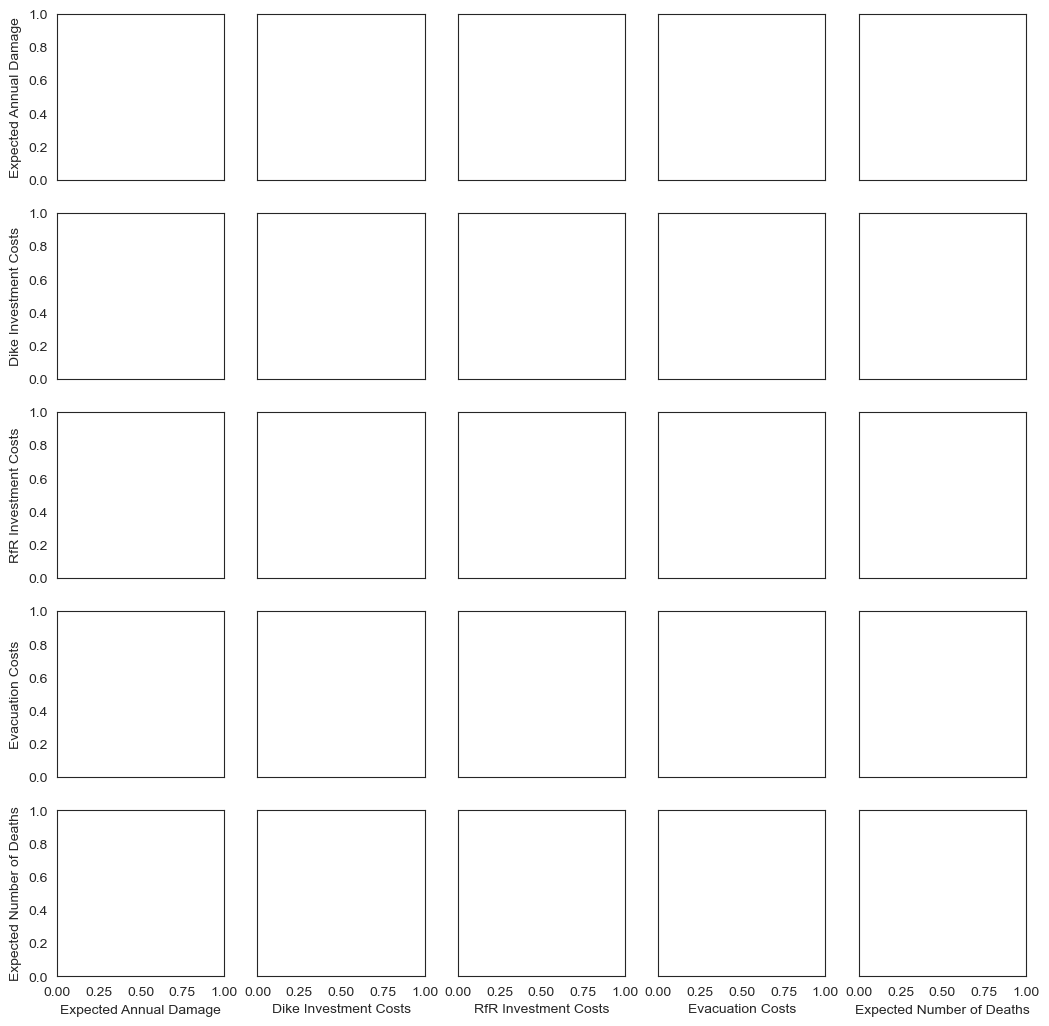

In [83]:
# Plot results
g= sns.pairplot(data, hue='policy', vars=outcomes.keys(), )
if saving_plots:
    plt.savefig(plots_path / "PF2_open_expl_policies.png", dpi=300)
plt.show()

## Optimization

Each epsilon value corresponds to a model outcome: expected damages, dike investment costs, RfR costs, evacuation costs, and casualties. 

Reflecting the Delta Commission’s mandate, we assign lower epsilon values to dike investment costs and casualties, emphasizing system safety and equity. We assign moderate values to damages and evacuation costs to allow trade-offs, and higher values to RfR costs(supporting nature-based solutions)

In [18]:
# Optimisation settings (see final report for more detail)
epsilon = [0.2, 0.1, 0.3, 0.2, 0.01]
#NFE settings
nfe = 15000 
    #higher NFEs take more time (depending on computer power), however a middleground needs to be found:
        #here we chose a value where the nfe is high enough and convergence can still be seen and was seen often in literature of similar models

## Reference Scenario
See report for more detail in why these values where chosen. While ideally multiple reference scenarios would be created, for the scope of this project, only the below was defined.

In [19]:
#Model specification
dike_model, planning_steps = get_model_for_problem_formulation(2)

reference_scenario = Scenario('reference', 
**{
    'discount rate 0': 1.5,
    'discount rate 1': 1.5,
    'discount rate 2': 1.5,
    'A.0_ID flood wave shape': 60, 
    'A.1_Bmax': 200, 
    'A.1_pfail': 0.15,
    'A.1_Brate': 7,
    'A.2_Bmax': 200, 
    'A.2_pfail': 0.15, 
    'A.2_Brate': 7,
    'A.3_Bmax': 200,
    'A.3_pfail': 0.15, 
    'A.3_Brate': 7,
    'A.4_Bmax': 200,
    'A.4_pfail': 0.15, 
    'A.4_Brate': 7,
    'A.5_Bmax': 200, 
    'A.5_pfail': 0.15,
    'A.5_Brate': 7
})

# === Optimization ===

# Set up data folder and remove "tmp" folder if left from previous runs
#optimization_data_path = "./MBDM_Final_Data/Optimization_Data"
#Path(optimization_data_path).mkdir(parents=True, exist_ok=True)
#tmppath = Path(optimization_data_path) / 'tmp'
#if tmppath.exists() and tmppath.is_dir():
 #   shutil.rmtree(tmppath)

## Convergence
Convergence is used to select robust policies. This approach will be using epsilon progress. 
(Hypervolume was considered, but it is computationally very expsensive, and e-progress can still provide a good sense of convergence without the computaiotn strain)

[MainProcess/INFO] pool started with 8 workers
15160it [45:59,  5.49it/s]                                                     
[MainProcess/INFO] optimization completed, found 434 solutions
[MainProcess/INFO] terminating pool


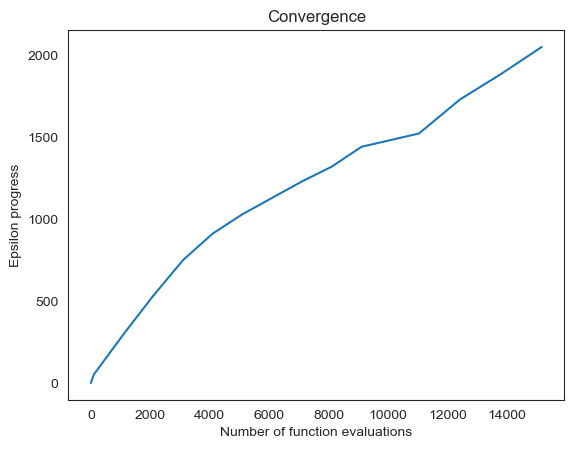

In [82]:
#set up convergence metrics with epsilon progress
convergence_metrics = [EpsilonProgress()]

with MultiprocessingEvaluator(dike_model) as evaluator:
    optimization_result, optimization_convergence = evaluator.optimize(
        nfe=nfe,
        searchover='levers',
        epsilons=epsilon,
        convergence=convergence_metrics,
        reference=reference_scenario
    )

# Plot convergence 
plt.figure()
plt.plot(optimization_convergence.nfe, optimization_convergence.epsilon_progress)
plt.xlabel('Number of function evaluations')
plt.ylabel('Epsilon progress')
plt.title('Convergence')

if saving_plots: #save the figure
        plt.savefig(plots_path / "epsilon_progress_convergence.png", dpi=300)
plt.show()

This reference scenario using the worst-case conditions of the 75th percentile. The epsilonmetric ensures that the optimization algorithm carefully balances trade-offs between the preferred objectives. 

The graph shows that the optimization algorithm is converging as expected. The beginning stages show rapid improvements, while later stages show diminishing returns.

## Constrain solutions


The first step now is to visualise the set of the selected solutions having done the first step of MORDM.

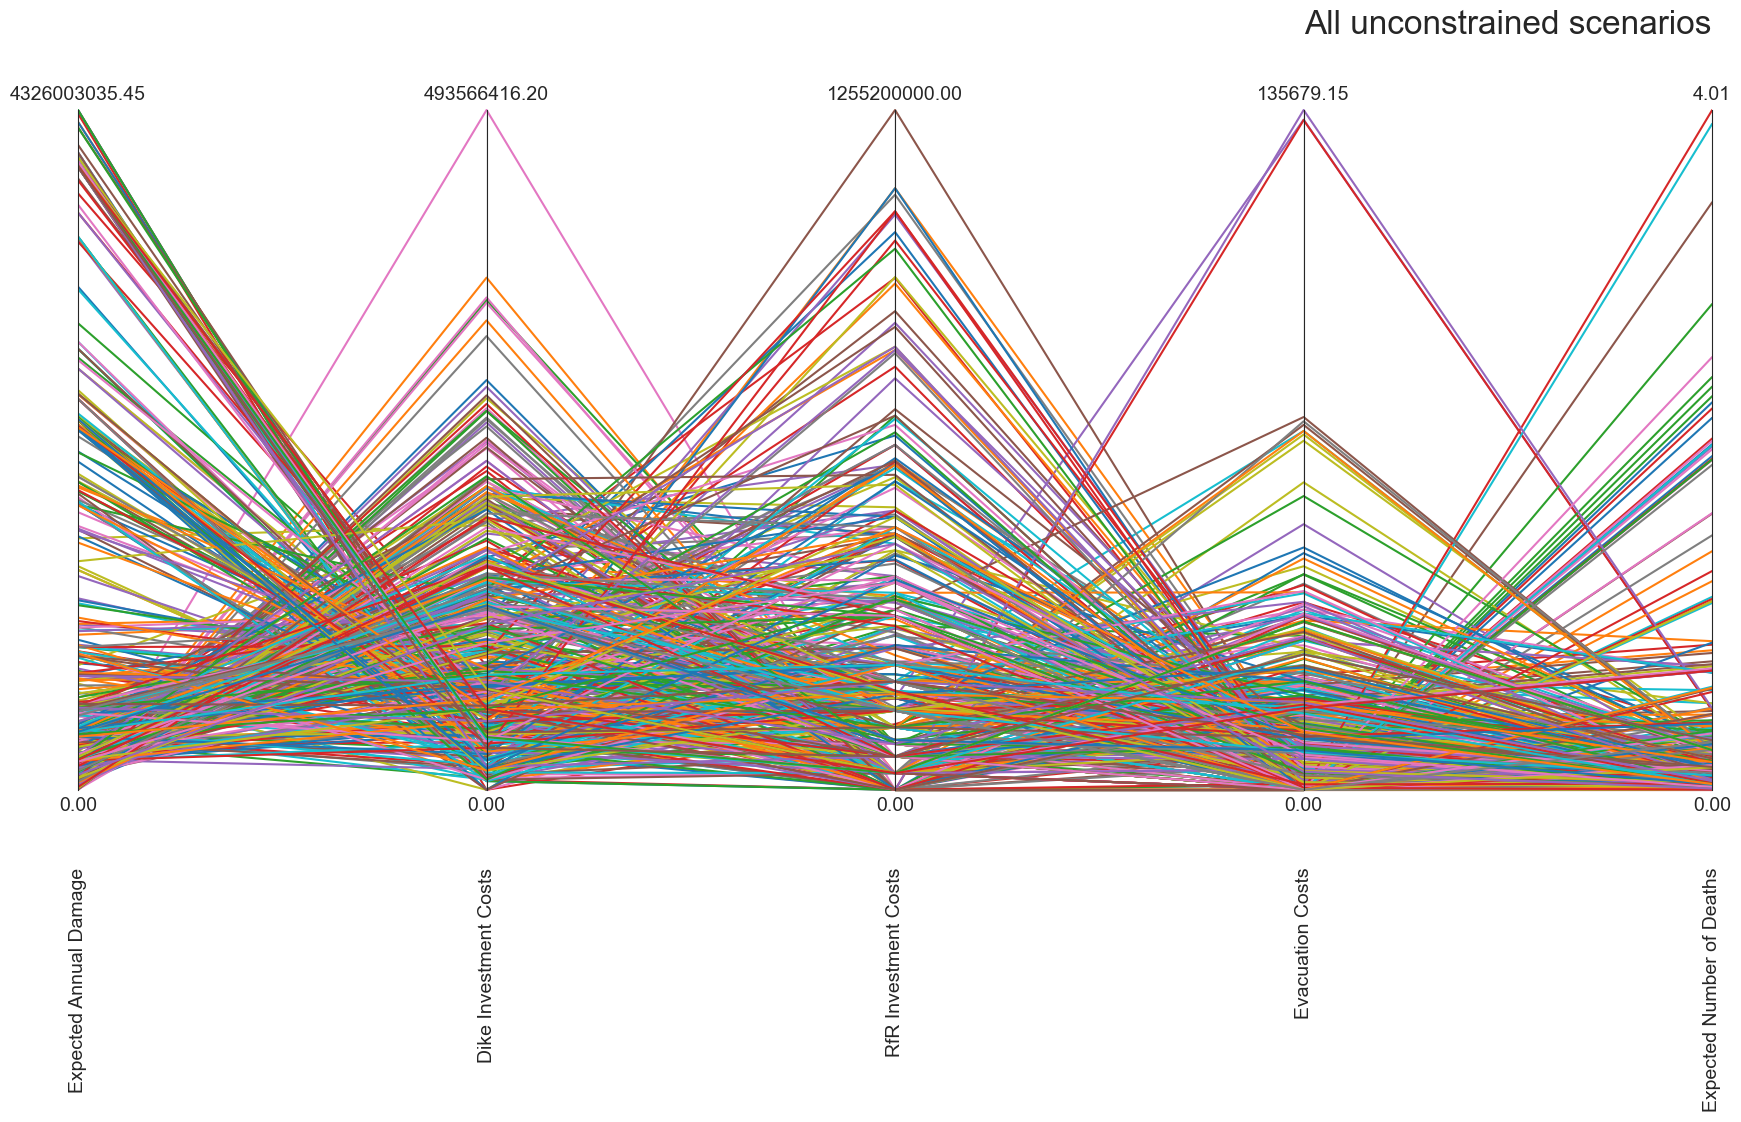

In [81]:
#getting the outcome names from dike model
outcome_names = [o.name for o in dike_model.outcomes] 

#converting optimization results to df
data = pd.DataFrame(optimization_result)
data = data.loc[:, outcome_names] #extract only columns

limits = parcoords.get_limits(data)

limits.loc[0, ['Expected Annual Damage','Dike Investment Costs','RfR Investment Costs', 'Evacuation Costs', 'Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data) #no legend becasue it would be too big  
fig = plt.gcf() 
plt.title("All unconstrained scenarios", fontsize=24)
fig.set_size_inches(20, 20)

if saving_plots: #save the figure
        plt.savefig(plots_path / "all_scenarios_paarcords", dpi=300)

plt.show()

Two min constraining factors are considered:
1) Expected number of deaths
2) Filter by dike investment cost (threshold €450 million)


In [22]:
#first constraint: filter by expected deaths to be very low, following Delta Mandate
constrained_optim_results = optimization_result[
    optimization_result['Expected Number of Deaths'] < 0.001] #note that deaths were already very low based on graph above

# Second constraint: filter by dike investment cost (threshold €450 million)
constrained_optim_results = constrained_optim_results[
    constrained_optim_results['Dike Investment Costs'] < 450_000_000]

# Removing the outcome columns to get a policy dataframe
optimization_policies = constrained_optim_results.drop([o.name for o in dike_model.outcomes], axis=1) #will create a df of constrainted policies 
optimization_policies  # print to have a look at constrained 

0_RfR 0  0_RfR 1  0_RfR 2  1_RfR 0  1_RfR 1  1_RfR 2  2_RfR 0  2_RfR 1  \
1          0        0        0        0        0        0        0        0   
12         0        1        0        0        0        0        0        0   
16         0        0        0        0        0        0        1        0   
86         0        0        0        0        0        0        0        0   
97         0        0        1        0        0        0        0        1   
346        0        1        1        0        0        1        1        0   
351        0        0        0        0        1        0        1        0   
355        1        0        0        0        1        1        0        1   
368        0        1        1        0        0        0        0        0   

     2_RfR 2  3_RfR 0  ...  A.2_DikeIncrease 2  A.3_DikeIncrease 0  \
1          1        0  ...                   0                   6   
12         0        0  ...                   0                   7   
16         1        0  ...                   0                   7   
86         1        0  ...                   0                   6   
97         0        0  ...                   0                   6   
346        0        0  ...                   0                   6   
351        0        0  ...                   0                   7   
355        1        0  ...                   0                   7   
368        1        1  ...                   0                   8   

     A.3_DikeIncrease 1  A.3_DikeIncrease 2  A.4_DikeIncrease 0  \
1                     1                   5                  10   
12                    0                   2                   5   
16                    3                   0                   4   
86                    6                   2                   5   
97                    0                   0                   6   
346                   0                   0                   4   
351                   0                   0                   3   
355                   0                   0                   5   
368                   0                   6                   4   

     A.4_DikeIncrease 1  A.4_DikeIncrease 2  A.5_DikeIncrease 0  \
1                     2                   4                   7   
12                    2                   0                   7   
16                    6                   0                   7   
86                    2                   3                   7   
97                    6                   0                   7   
346                   5                   0                   7   
351                   0                   2                   7   
355                   6                   0                   7   
368                   0                   1                   7   

     A.5_DikeIncrease 1  A.5_DikeIncrease 2  
1                     0                   0  
12                    3                   0  
16                    0                   0  
86                    3                   0  
97                    0                   0  
346                   0                   0  
351                   0                   0  
355                   0                   0  
368                   0                   0  

[9 rows x 31 columns]

In [23]:

# Select columns with names of all model outcomes
outcomes_constrained = constrained_optim_results.loc[:, [o.name for o in dike_model.outcomes]] #Select all rows and the columns with names of all model outcomes
outcome_limits_constrained = parcoords.get_limits(outcomes_constrained)


In [24]:
#Saving the data
if saving_results_data:
    optimization_result.to_csv(results_path + "/optimization_result.csv")
    constrained_optim_results.to_csv(results_path + "/constrained_optimization_results.csv")
    optimization_policies.to_csv(results_path + "/optimization_policies.csv")

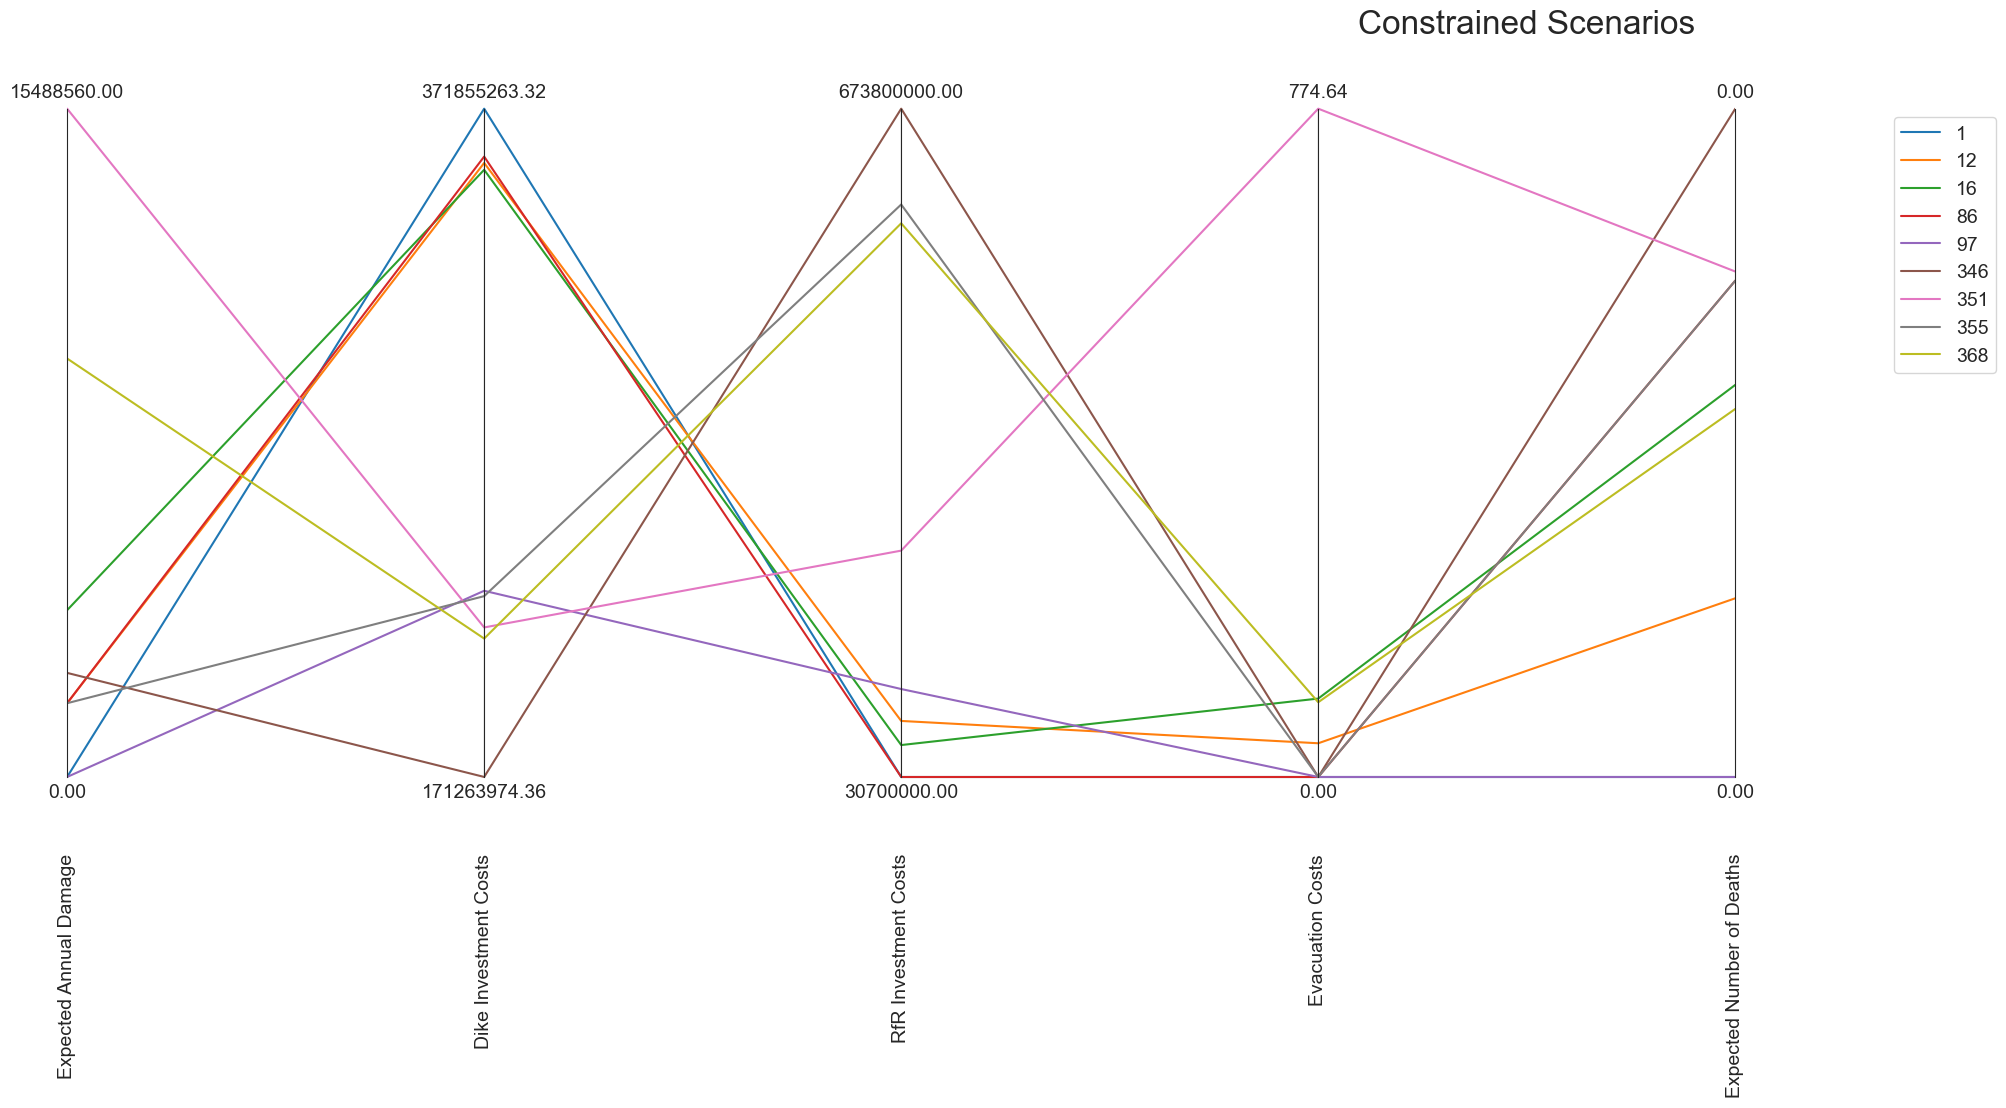

In [80]:
#plotting constrained solutions
colours = sns.color_palette()

paraxes = parcoords.ParallelAxes(outcome_limits_constrained)

# Plot each scenario's outcome
for i, (index, row) in enumerate(outcomes_constrained.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colours[i])

# Add the legend
paraxes.legend()

plt.title("Constrained Scenarios", fontsize=24)
fig = plt.gcf()
fig.set_size_inches(20, 20)

if saving_plots: #save the figure
        plt.savefig(plots_path / "constrainted_scenarios_paarcords", dpi=300)

plt.show()

Every scenario is displayed in different colours. On the x axis you can see how each performs compared to the outcomes.

## Uncertainty

Evaluate the candidate solutions, after constraining them, under uncertainty once again. Performing experiments with 5000 scenarios for each of the selected policy options

In [26]:
# Build list of policies
policies_to_evaluate = []

for i, policy in optimization_policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))
n_scenarios = 5000 # the amount of scenarios for each policy option
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios, policies_to_evaluate)

[MainProcess/INFO] pool started with 8 workers
[MainProcess/INFO] performing 5000 scenarios * 9 policies * 1 model(s) = 45000 experiments
100%|██████████████████████████████████| 45000/45000 [2:26:26<00:00,  5.12it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [27]:
experiments

A.0_ID flood wave shape    A.1_Bmax A.1_Brate  A.1_pfail    A.2_Bmax  \
0                           14  100.300502       1.5   0.244816  177.088264   
1                           45  218.571057       1.0   0.857074   58.888626   
2                           53  132.766161      10.0   0.599604  176.662425   
3                           45   37.909630       1.5   0.590066  101.007758   
4                          109  119.084679      10.0   0.117352  169.439011   
...                        ...         ...       ...        ...         ...   
44995                       71   97.215886      10.0   0.649405   60.066635   
44996                       89   92.074637      10.0   0.399355  124.266636   
44997                       29   72.100363       1.5   0.012617  263.230111   
44998                      123  320.261023       1.0   0.273666  105.735435   
44999                       72  169.681873       1.5   0.549121  348.895056   

      A.2_Brate  A.2_pfail    A.3_Bmax A.3_Brate  A.3_pfail  ...  \
0          10.0   0.214213  177.472910       1.5   0.900374  ...   
1          10.0   0.795125  334.487200       1.0   0.594915  ...   
2          10.0   0.648259  243.040989       1.5   0.564049  ...   
3          10.0   0.401487  104.800072       1.5   0.926677  ...   
4           1.0   0.111433   40.967602      10.0   0.213548  ...   
...         ...        ...         ...       ...        ...  ...   
44995       1.0   0.939152  289.492040      10.0   0.947445  ...   
44996      10.0   0.268507  329.966394      10.0   0.545562  ...   
44997       1.5   0.097311   62.159154       1.5   0.674446  ...   
44998       1.0   0.784010  319.374355       1.0   0.950402  ...   
44999       1.0   0.938403  344.177505       1.5   0.989471  ...   

       A.3_DikeIncrease 2 A.4_DikeIncrease 0  A.4_DikeIncrease 1  \
0                       5                 10                   2   
1                       5                 10                   2   
2                       5                 10                   2   
3                       5                 10                   2   
4                       5                 10                   2   
...                   ...                ...                 ...   
44995                   6                  4                   0   
44996                   6                  4                   0   
44997                   6                  4                   0   
44998                   6                  4                   0   
44999                   6                  4                   0   

       A.4_DikeIncrease 2 A.5_DikeIncrease 0  A.5_DikeIncrease 1  \
0                       4                  7                   0   
1                       4                  7                   0   
2                       4                  7                   0   
3                       4                  7                   0   
4                       4                  7                   0   
...                   ...                ...                 ...   
44995                   1                  7                   0   
44996                   1                  7                   0   
44997                   1                  7                   0   
44998                   1                  7                   0   
44999                   1                  7                   0   

      A.5_DikeIncrease 2 scenario policy     model  
0                      0      200      1  dikesnet  
1                      0      201      1  dikesnet  
2                      0      202      1  dikesnet  
3                      0      203      1  dikesnet  
4                      0      204      1  dikesnet  
...                  ...      ...    ...       ...  
44995                  0     5195    368  dikesnet  
44996                  0     5196    368  dikesnet  
44997                  0     5197    368  dikesnet  
44998                  0     5198    368  dikesnet  
44999                  0

In [28]:
outcomes

{'Expected Annual Damage': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.60809745e+09, 0.00000000e+00, 0.00000000e+00]),
 'Dike Investment Costs': array([3.71855263e+08, 3.71855263e+08, 3.71855263e+08, ...,
        2.12801227e+08, 2.12801227e+08, 2.12801227e+08]),
 'RfR Investment Costs': array([3.070e+07, 3.070e+07, 3.070e+07, ..., 5.635e+08, 5.635e+08,
        5.635e+08]),
 'Evacuation Costs': array([    0.        ,     0.        ,     0.        , ...,
        30714.33563476,     0.        ,     0.        ]),
 'Expected Number of Deaths': array([0.        , 0.        , 0.        , ..., 0.19508692, 0.        ,
        0.        ])}

## Scenario Discovery 

### PRIM 
The penultimate step of the MORDM is to conduct a scenraio discovery using PRIM as defined by Bryan & Lempert (2010). Because the policies are evaluated on a series of experiments, the constraint on deaths, considering safety and wellbeing are fundamental parts of the Delta Commission mandate, is re-applied to ensure the policies behave within the defined threshold.

Robustness measures are sensitive to the scenarios under which a policy is evaluated. Thus, by conducting the scneario discovery first, we can identify which uncertainties (or combinations of them) would lead to vulnerable system behavior. 

In [29]:
#cleaning up data, only leaving outcomes
columns_to_drop = ['A.1_DikeIncrease 0','A.1_DikeIncrease 1','A.1_DikeIncrease 2','A.2_DikeIncrease 0','A.2_DikeIncrease 1','A.2_DikeIncrease 2','A.3_DikeIncrease 0','A.3_DikeIncrease 1','A.3_DikeIncrease 2','A.4_DikeIncrease 0','A.4_DikeIncrease 1','A.4_DikeIncrease 2','A.5_DikeIncrease 0','A.5_DikeIncrease 1','A.5_DikeIncrease 2', 'policy']
columns_to_drop += ['0_RfR 0','0_RfR 1','0_RfR 2','1_RfR 0','1_RfR 1','1_RfR 2','2_RfR 0','2_RfR 1','2_RfR 2','3_RfR 0','3_RfR 1','3_RfR 2','4_RfR 0','4_RfR 1','4_RfR 2','EWS_DaysToThreat']

cleaned_experiments = experiments.copy()
cleaned_experiments.drop(columns_to_drop, axis=1, inplace=True)

In [30]:
# Apply PRIM
x = cleaned_experiments
y = outcomes['Expected Number of Deaths'] <= 0.001 # keeping deaths very low
prim_alg = prim.Prim(x,y, threshold = 0.35, peel_alpha=0.1)
box = prim_alg.find_box()

[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 45000 points remaining, containing 31217 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.387, coverage: 0.5578691097799277, density: 1.0 restricted_dimensions: 5


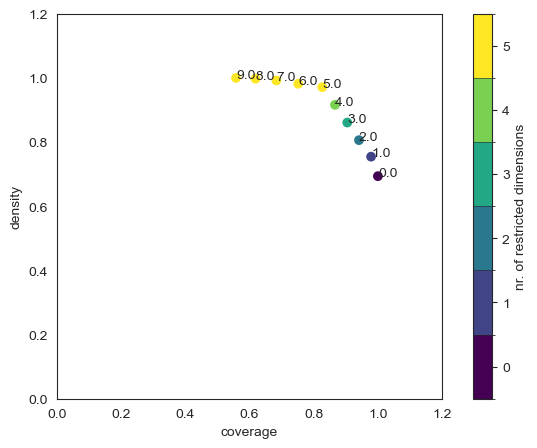

In [78]:
box.show_tradeoff(annotated=True)
fig = plt.gcf()  
fig.set_size_inches(8, 5)

if saving_plots:
    plt.savefig(plots_path / "prim_tradeoff.png", dpi=300)
    
plt.show()

#### Descision on Coverage and Density tradeoff
Bryant & Lembert (2010) discuss tradeoff between density, coverage and interpretability. Instead of choosing a specific single metric to maximise, we chose a box with (roughly based off the paper) a density above  0.8, reasonable coverage of around: 0.8, and a manageable number of restricted dimensions, making it a suitable basis for identifying robust strategies under uncertainty.


In [32]:
point = 5 # chosen a bit randomly 
box.inspect(point)

coverage        0.826569
density         0.971206
id              5.000000
k           25803.000000
mass            0.590400
mean            0.971206
n           26568.000000
res_dim         5.000000
Name: 5, dtype: float64

              box 5                                  
                min       max       qp value qp value
A.1_pfail  0.097007  0.999919   0.000000e+00      NaN
A.3_pfail  0.100181  0.999951   0.000000e+00      NaN
A.4_pfail  0.098803  0.999845   0.000000e+00      NaN
A.5_pfail  0.099987  0.999890   0.000000e+00      NaN
A.2_pfail  0.096004  0.999965  7.346358e-303      NaN



[None]

From this inspection it becoems clear that the low utility in box 5 is primarily associated with high values across all A.#_pfail parameters --> which represent the failure vulnerability of individual dikes (A.1 to A.5). this causes easy duke failure at low water levels, and these high values strongly correlate with poor system performance (qp-values near zero). This vulnerability (coverage 0.72, mass 0.59, density 1.0) leads to frequent severe damage and risk. Below will inspect this in more depth.


This table shows the box limits. The darker gray background is the full range. The blue lines indicate the limits identified by PRIM for the box being inspected. The blue number indicate the limit. The number between brackets behind each parameter on the left hand side is the quasi p-value. The coverage and density are shown in the top right hand corner. 

However, as the coverage found is quite low, and in general, PRIM struggles to explain the problem without restricting a significant number of dimensions. This model illustrates that for highly non-linear models (such as this one) with many uncertain parameters, PRIM struggles to produce good results. This is largely due to PRIM trying to find orthogonal subspaces in the model input space. In case of non-linear interactions, the cases of interest are unlikely to be nicely orthogonal. Various recent journal papers have been experimenting with other rule induction algorithms that make less restrictive assumptions. However, this often comes at the expense of interpretatiblity.

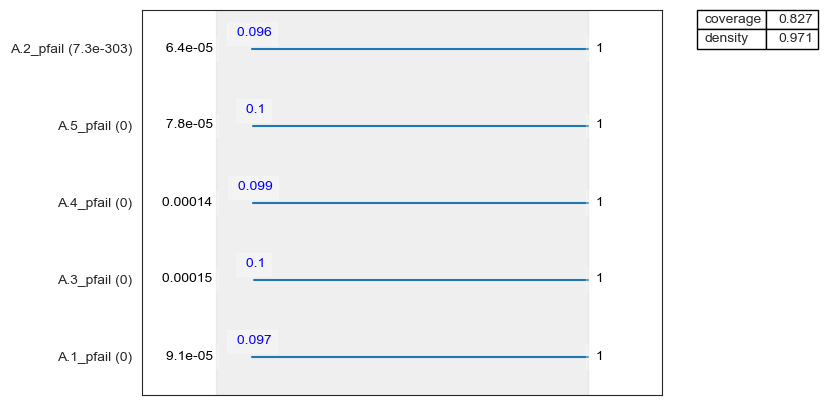

<Figure size 640x480 with 0 Axes>

In [77]:
# Inspect PRIM results by inspecting box limits 
box.inspect(point, style='graph')
fig = plt.gcf()  
fig.set_size_inches(8, 5)  
plt.show()

if saving_plots:
    plt.savefig(plots_path / "prim_inspect_graph.png", dpi=300)

In [34]:
box.resample(point)

[MainProcess/INFO] resample 0
[MainProcess/INFO] resample 1
[MainProcess/INFO] resample 2
[MainProcess/INFO] resample 3
[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


reproduce coverage  reproduce density
A.1_pfail                             100.0              100.0
A.2_pfail                             100.0              100.0
A.3_pfail                             100.0              100.0
A.4_pfail                             100.0              100.0
A.5_pfail                             100.0              100.0
A.0_ID flood wave shape                 0.0                0.0
A.1_Bmax                                0.0                0.0
A.1_Brate                               0.0                0.0
A.2_Bmax                                0.0                0.0
A.2_Brate                               0.0                0.0
A.3_Bmax                                0.0                0.0
A.3_Brate                               0.0                0.0
A.4_Bmax                                0.0                0.0
A.4_Brate                               0.0                0.0
A.5_Bmax                                0.0                0.0
A.5_Brate                               0.0                0.0
discount rate 0                         0.0                0.0
discount rate 1                         0.0                0.0
discount rate 2                         0.0                0.0

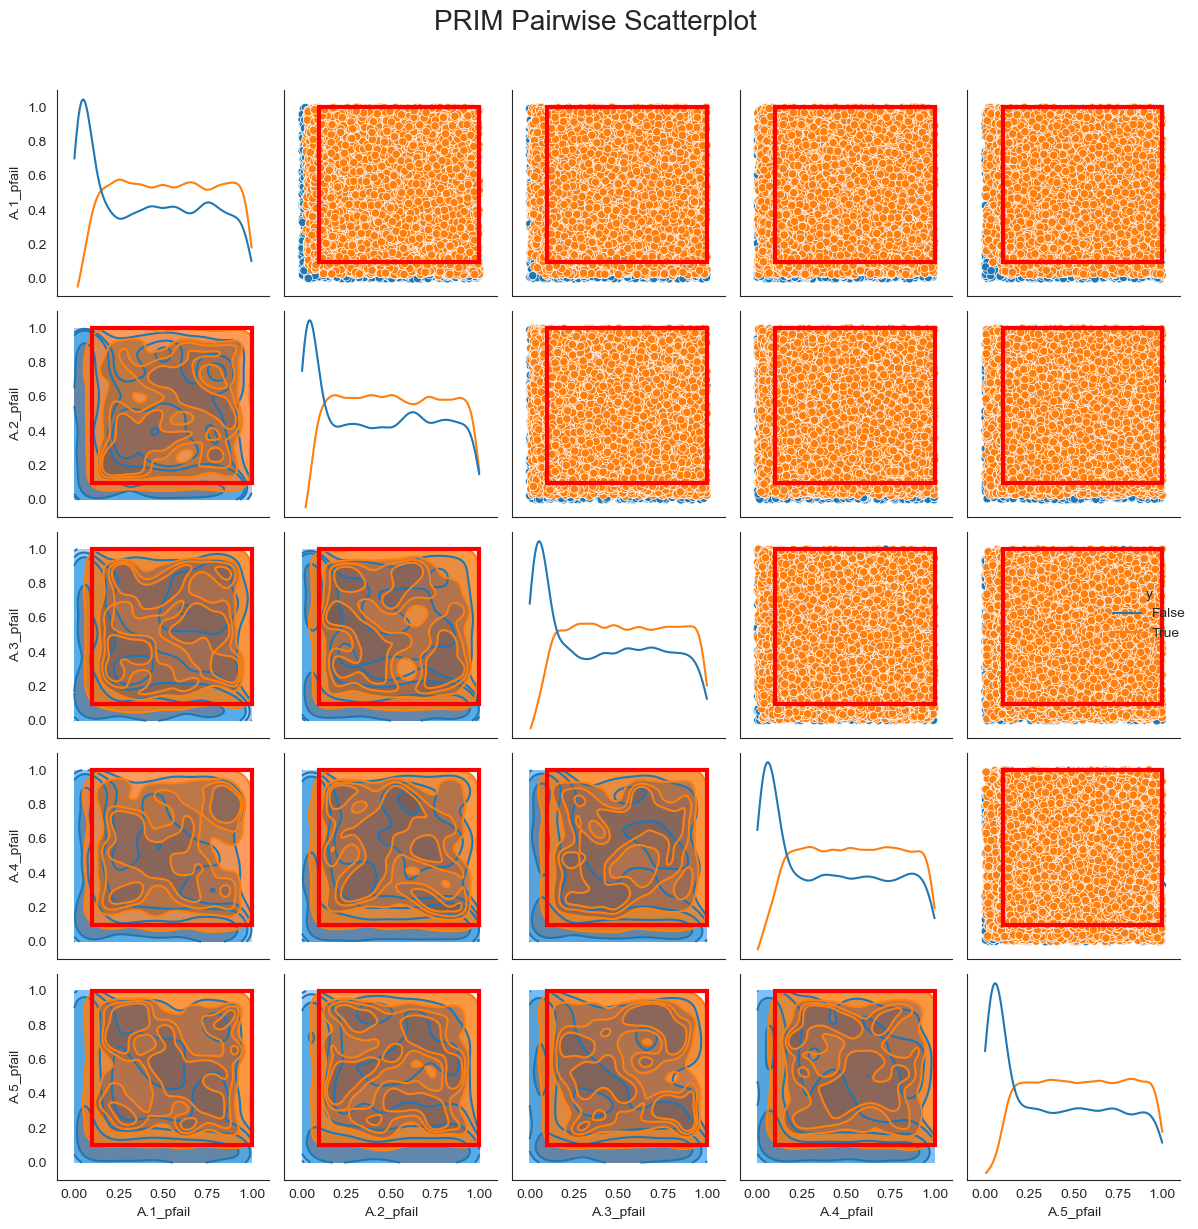

In [76]:
box.select(5)
box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
fig.suptitle("PRIM Pairwise Scatterplot", fontsize=20, y=1.02) 
plt.tight_layout()

if saving_plots:
    plt.savefig(plots_path / "prim_box_scatter.png", dpi=300)
plt.show()

This pairwise scatterplot displays cases of interest in orange and those that are not of interest in blue. On the diagonal, the Gaussian kernel density estimates for both groups can be seen. The red square highlights the determined box limits for each pair of parameters, so you can assess these limits. This plot showed significant overlap between the classes across all feature combinations, indicating poor separability with no clear patterns within the regions of interest emerge. Thus, this highlights a need for further anlaysis.

## Robustness

The final step of our MORDM optimisation process is the evaluation of robustness. Now have a large number of candidate solutions/policies, the robustness analysis much more targeted and policy-relevant. hat we can re-evaluate over the various deeply uncertain factors to assess their robustness against uncertainties.

Here, we decide to use two complimentary robustenss metrics: Signal-to-noise ratio and Maximum Regret

These two work well together as, due to delta's mandate, different outcomes require different robustness considerations allowed. This will work well for the different otucomes as: S-t-N is best used for understanding average performance and identifying stable and reliable decisions. This will make it really useful for assessing financial outcomes like our outcomes:
- Expected Annual Damage
- Dike Investment Costs
- RfR Investment Costs
- Evacuation Costs.
These are areas where consistent, predictable results are valuable.

Complementing this is max regret that on worst-case scenarios. It is much more appropriate for high-stakes outcomes where failure to perform as 'promised' has severe consequences. Clearly, it should be used for metrics like Expected Number of Deaths. We are going to include focusing at evacuation cost here as where minimizing the potential for catastrophic loss, even when it’s unlikely on average.

However, its important to look at ALL outcomes for all the metrics to get an overview. The above is just a light guideline.

### Signal to Noise Ratio

The signal-to-noise ratio assesses how consistently a policy performs relative to variability. Given that the Delta Commissioner’s mandate prioritizes minimizing deaths, costs, and damages, a low signal-to-noise ratio is preferred. This metric is especially relevant for outcomes, exactly like our outcome "expected number of deaths" where there is a strict threshold to meet and almost NO tolerance for deviation.

In [36]:
#setting up function for signal to noise 
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    if std==0:
        std = 1
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std
overall_scores = {}


In [37]:
#loop over policies
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy'] == policy

    for outcome in dike_model.outcomes:
        value = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores

scores = pd.DataFrame.from_dict(overall_scores).T #transposing df and dispalying contents 
scores


Expected Annual Damage  Dike Investment Costs  RfR Investment Costs  \
1              4.857844e+15           2.216430e+01            30700000.0   
12             4.884416e+15           3.555752e+08            84600000.0   
16             1.138776e+15           3.535127e+08            61400000.0   
346            1.752564e+16           5.104064e+00           673800000.0   
351            1.511395e+16           6.441521e+00           248500000.0   
355            9.129743e+15           2.255362e+08           581600000.0   
368            8.269277e+16           2.128012e+08           563500000.0   
86             4.235540e+15           3.574719e+08            30700000.0   
97             3.233851e+16           6.769462e+00           115300000.0   

     Evacuation Costs  Expected Number of Deaths  
1        0.000000e+00                   0.003347  
12       8.162133e+05                   0.000531  
16       4.752642e+05                   0.000095  
346      0.000000e+00                   0.010720  
351      7.720805e+06                   0.000112  
355      0.000000e+00                   0.004511  
368      1.353404e+07                   0.000511  
86       0.000000e+00                   0.002574  
97       2.403804e+06                   0.002300

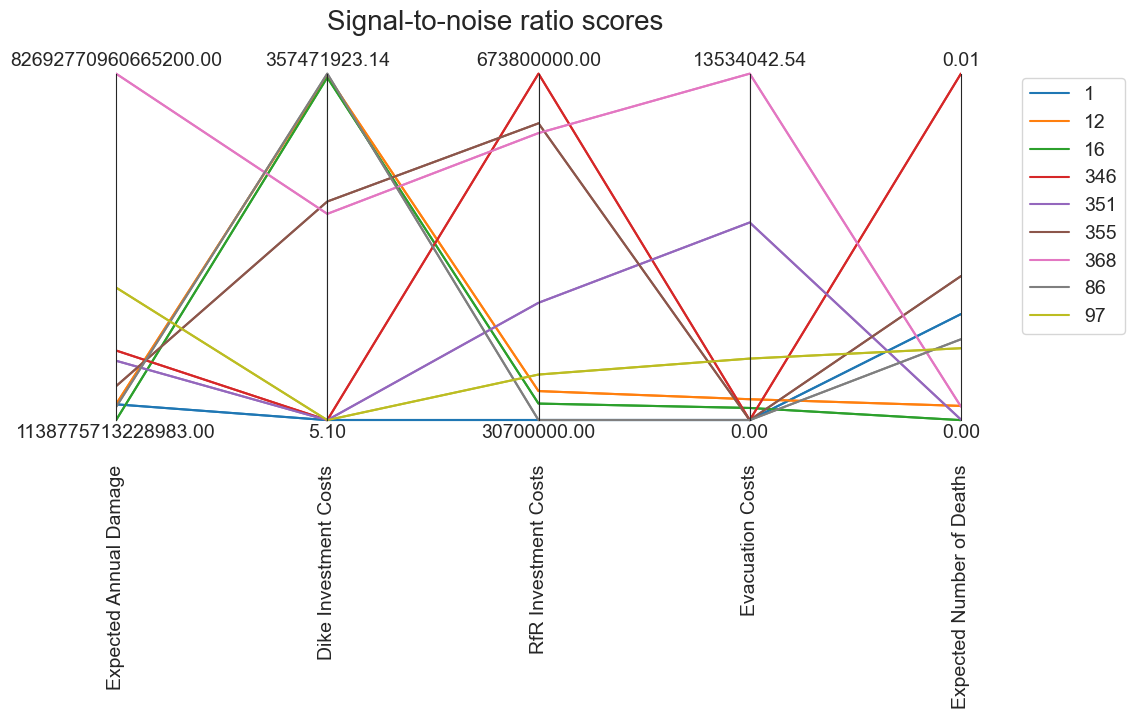

In [75]:
#Plot the pool of scores
score_data = scores
score_limits = parcoords.get_limits(score_data)

# Save score data
if saving_results_data:
    scores.to_csv(results_path / "sn_scores.csv")

paraxes = parcoords.ParallelAxes(score_limits) #setting up parcoords plots


fig = plt.gcf()
fig.set_size_inches(10, 7)

paraxes.plot(score_data)

#plot each score scenario and add a label and then legend
for i, (index, row) in enumerate(score_data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colours[i])

paraxes.legend()

fig.suptitle("Signal-to-noise ratio scores", fontsize=20, y=1.02) 

if saving_plots:#saving figure
    plt.savefig(plots_path / "parcoords_s_t_n.png", dpi=300)


plt.show()

# Maximum Regret

After having performed signal-to-noise to assess consistency, max-regret checks robustness by evaluating how much worse each policy performs compared to the best one in each scenario, highlighting vulnerability to worst-case outcomes. These two approaches balance eachother out very well. We aim for lowest maximum regret in all the outcomes.


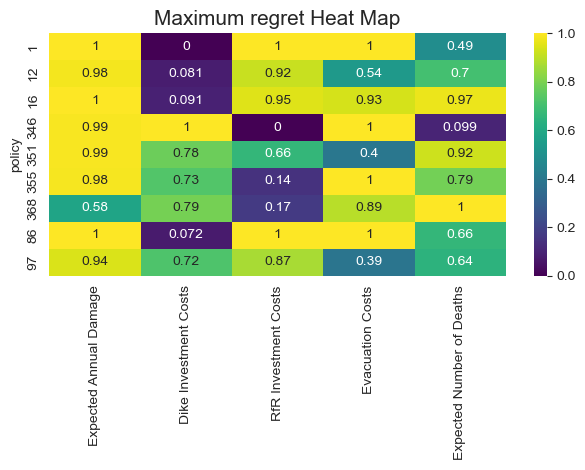

In [74]:
#Calculate Miximum Regret 
def calculate_regret(data, best):
    return np.abs(best-data)

overall_regret = {}
max_regret = {}
for outcome in dike_model.outcomes:
    policy_column = experiments['policy']

    #Create a DataFrame with all the relevant information
    data = pd.DataFrame({
        outcome.name: outcomes[outcome.name],
        "policy": experiments['policy'],
        "scenario": experiments['scenario']
    })

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from pivoting
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()


#Create heatmap
max_regret_df = pd.DataFrame(max_regret)
plt.figure()
sns.heatmap(max_regret_df/max_regret_df.max(), cmap='viridis', annot=True)
plt.title("Maximum regret Heat Map", fontsize=15)
plt.tight_layout()

if saving_plots:
    plt.savefig(plots_path / "maxregret_heatmap.png", dpi=300)

This heatmat shows the different policies performing against the outcomes. Max-regret should be minimised, and is more critical than to noise by adressing the worst-case scenario. Thus, looking aiming the focus here to the otucomes investment costs and 



In [ ]:

data = max_regret_df
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)

colour_map = matplotlib.colormaps['viridis']
n = data.shape[0]

for i, (index, row) in enumerate(data.iterrows()):
    color = colour_map(i / (n - 1))  # normalized index for colormap
    paraxes.plot(row.to_frame().T, label=str(index), color=color)

fig = plt.gcf()
fig.set_size_inches(7, 7)

paraxes.legend()
fig.suptitle("Maximum Regret Heat Map", fontsize=15)
fig.subplots_adjust(top=0.92)

if saving_plots:
   plt.savefig(plots_path / "maxregret_parcoords.png", dpi=300)

In [41]:
policy_regret = collections.defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]


In [42]:
# Number of policies to plot
n_policies = len(policy_regret)  
n_policies

9

Text(0.5, 1.02, 'Maximum Regret Box-and-whisker Plots')

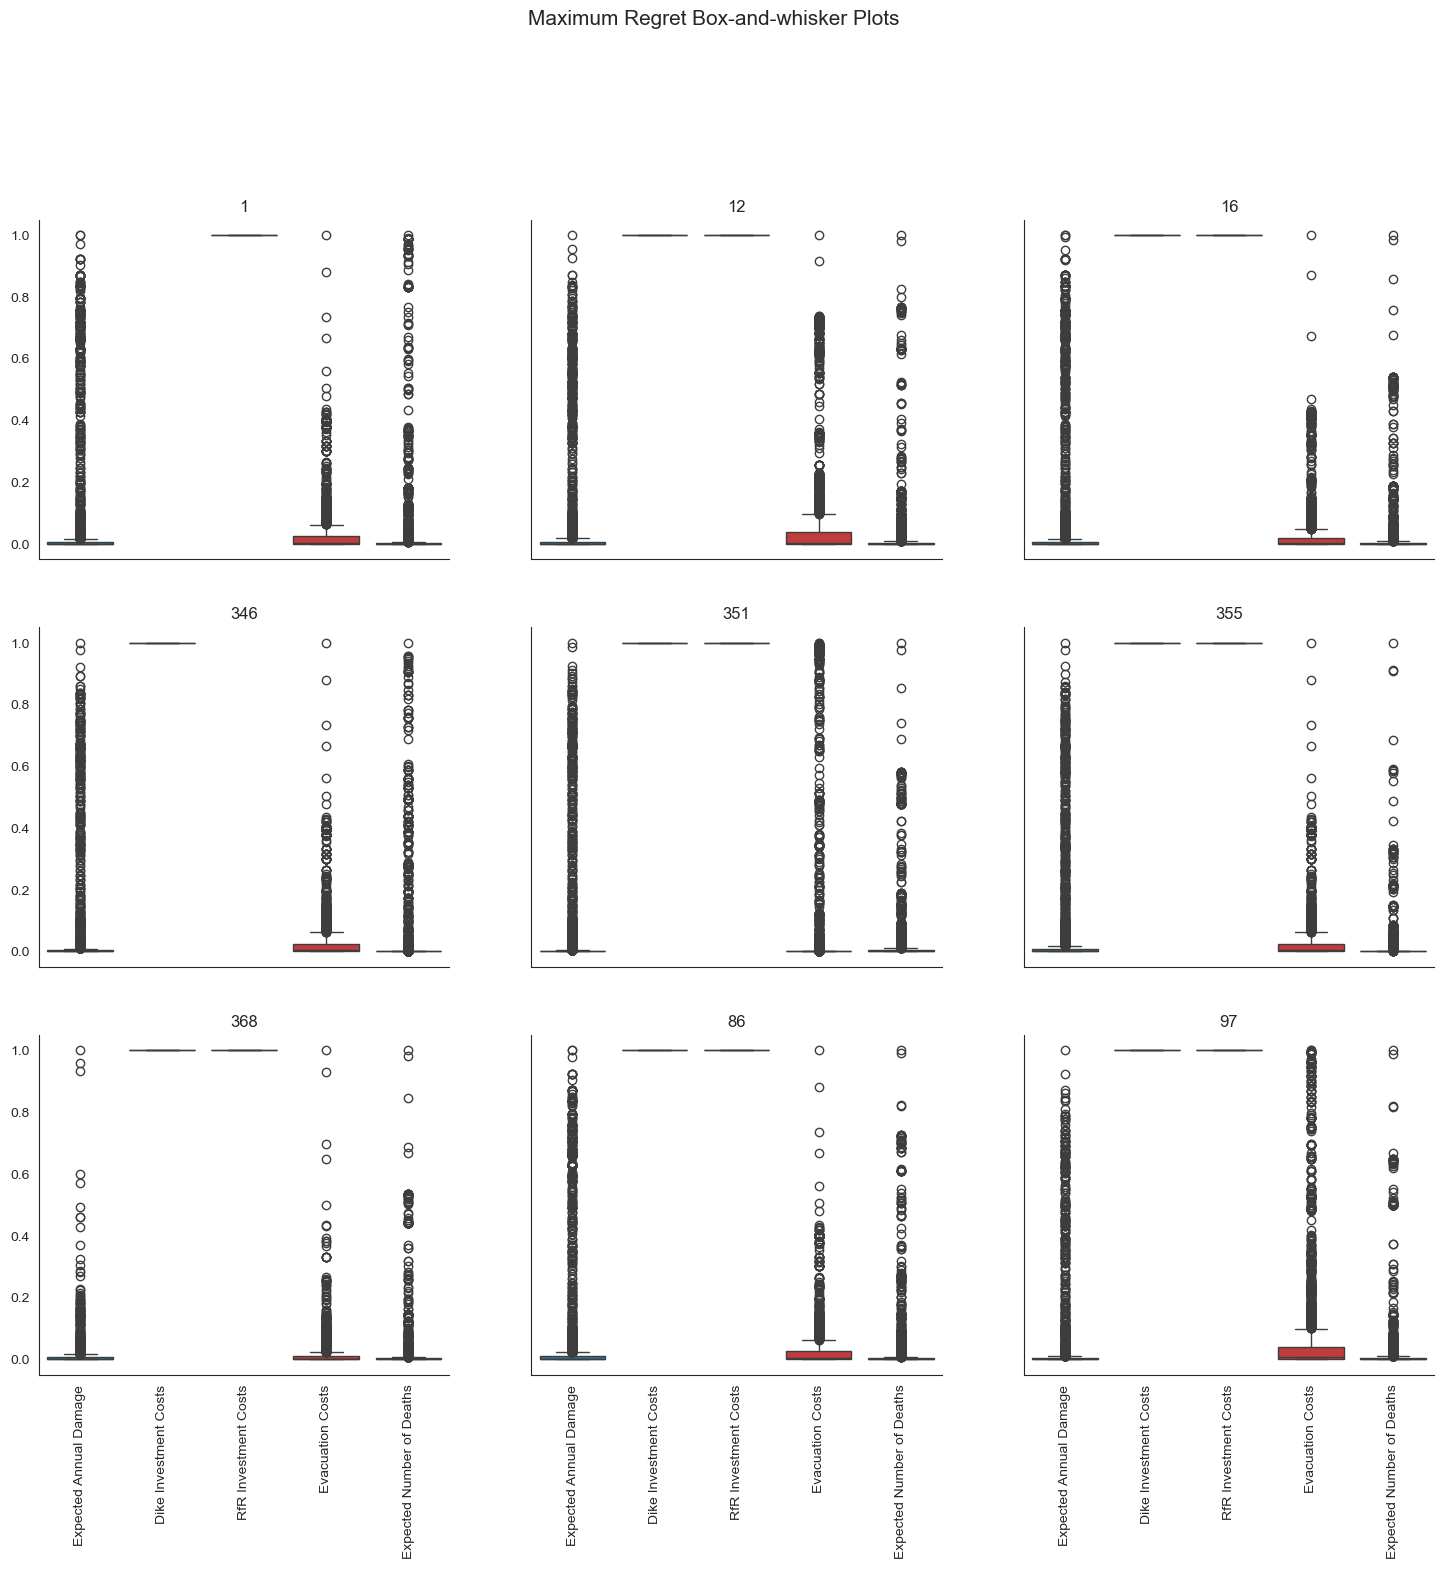

In [43]:
#making sure visualisation works and doesn't overlap
ncols = 3
nrows = math.ceil(n_policies / ncols)

#plot 
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*5), sharey=True, sharex=True) # adjusting figure size 
axes = axes.flatten()  # Flatten in case axes is 2D

for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)
    
    # Normalize data for fair visual comparison
    data = data / data.max(axis=0)
    
    sns.boxplot(data=data, ax=ax)
    sns.despine(ax=ax)
    ax.set_title(str(policy))
    ax.tick_params(axis='x', labelrotation=90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Maximum Regret Box-and-whisker Plots", fontsize=15, y=1.02)  

In [73]:
# Save data and images
plt.tight_layout(rect=[0, 0, 1, 0.97])

if saving_results_data:
    pd.DataFrame(policy_regret).to_csv(results_path / "maxregret_policy_regret.csv")
if saving_plots:
   plt.savefig(plots_path / "maxregret_cat_whiskers.png", dpi=300)

<Figure size 640x480 with 0 Axes>